In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model

In [51]:
df_dataset = pd.read_csv("heart_disease_uci.csv")
df_dataset

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


In [52]:
df = df_dataset.drop('id', axis=1)

In [53]:
df['trestbps'] = df['trestbps'].fillna(round(df_dataset['trestbps'].median(), 2))
df['chol'] = df['chol'].fillna(round(df_dataset['chol'].median(), 2))
df['thalch'] = df['thalch'].fillna(round(df_dataset['thalch'].median(), 2))
df['oldpeak'] = df['oldpeak'].fillna(round(df_dataset['oldpeak'].median(), 2))
df['ca'] = df['ca'].fillna(round(df_dataset['ca'].median(), 2))

In [54]:
df['fbs'] = df['fbs'].fillna(df['fbs'].mode()[0])
df['restecg'] = df['restecg'].fillna(df['restecg'].mode()[0])
df['exang'] = df['exang'].fillna(df['exang'].mode()[0])
df['slope'] = df['slope'].fillna(df['slope'].mode()[0])
df['thal'] = df['thal'].fillna(df['thal'].mode()[0])

In [55]:
def grabColNames(dataframe, catTh=10, carTh=20):
    catCols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    numButCat = [col for col in dataframe.columns if dataframe[col].nunique() < catTh and
                dataframe[col].dtypes != "O"]
    catButCar = [col for col in dataframe.columns if dataframe[col].nunique() > carTh and
                dataframe[col].dtypes == "O"]
    catCols = catCols + numButCat
    catCols = [col for col in catCols if col not in catButCar]

    # numCols
    numCols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numCols = [col for col in numCols if col not in numButCat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'catCols: {len(catCols)}')
    print(f'numCols: {len(numCols)}')
    print(f'catButCar: {len(catButCar)}')
    print(f'numButCat: {len(numButCat)}')
    return catCols, numCols, catButCar, numButCat


catCols, numCols, catButCar, numButCat = grabColNames(df)
numCols = [col for col in numCols if col not in "id"]

Observations: 920
Variables: 15
catCols: 10
numCols: 5
catButCar: 0
numButCat: 4


In [56]:
def outlierThresholds(dataframe, colName, q1=0.25, q3=0.75):
    quartile1 = dataframe[colName].quantile(q1)
    quartile3 = dataframe[colName].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit

In [57]:
def checkOutlier(dataframe, colName):
    lowLimit, upLimit = outlierThresholds(dataframe, colName)
    if dataframe[(dataframe[colName] > upLimit) | (dataframe[colName] < lowLimit)].any(axis=None):
        return True
    else:
        return False

print("Age: Low limit, up limit",outlierThresholds(df, "age"))
print("Trestbps: Low limit, up limit",outlierThresholds(df, "trestbps"))
print("Chol: Low limit, up limit",outlierThresholds(df, "chol"))
print("Thalch: Low limit, up limit",outlierThresholds(df, "thalch"))
print("Oldpeak: Low limit, up limit",outlierThresholds(df, "oldpeak"))
print("Ca: Low limit, up limit",outlierThresholds(df, "ca"))

Age: Low limit, up limit (27.5, 79.5)
Trestbps: Low limit, up limit (90.0, 170.0)
Chol: Low limit, up limit (43.875, 400.875)
Thalch: Low limit, up limit (66.0, 210.0)
Oldpeak: Low limit, up limit (-2.25, 3.75)
Ca: Low limit, up limit (0.0, 0.0)


In [58]:
for col in numCols:
    print(col, checkOutlier(df, col))

age False
trestbps True
chol True
thalch True
oldpeak True


In [59]:
def replace_with_thresholds(dataframe, variable):
    lowLimit, upLimit = outlierThresholds(dataframe, variable)                           
    dataframe.loc[(dataframe[variable] > upLimit), variable] = upLimit
    dataframe.loc[(dataframe[variable] < lowLimit), variable] = lowLimit                                        

for col in numCols:
    print(col, checkOutlier(df_dataset, col))                      # Outlier var mi diye sorduk.

for col in numCols:
    replace_with_thresholds(df_dataset, col)                        # Esik degerler ile degistirdik.

for col in numCols:
    print(col, checkOutlier(df_dataset, col)) 

age False
trestbps True
chol True
thalch True
oldpeak True
age False
trestbps False
chol False
thalch False
oldpeak False


In [60]:
replace_with_thresholds(df, "trestbps") 

In [61]:
replace_with_thresholds(df, "chol") 

In [62]:
replace_with_thresholds(df, "thalch")

In [63]:
replace_with_thresholds(df, "oldpeak")

In [64]:
cols=df.select_dtypes(include=['object']).columns
print(cols)

Index(['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal'], dtype='object')


In [65]:
le=LabelEncoder()
df[cols]=df[cols].apply(le.fit_transform)
df.head(10)

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,1,0,3,145.0,233.0,True,0,150.0,False,2.3,0,0.0,0,0
1,67,1,0,0,160.0,286.0,False,0,108.0,True,1.5,1,3.0,1,2
2,67,1,0,0,120.0,229.0,False,0,129.0,True,2.6,1,2.0,2,1
3,37,1,0,2,130.0,250.0,False,1,187.0,False,3.5,0,0.0,1,0
4,41,0,0,1,130.0,204.0,False,0,172.0,False,1.4,2,0.0,1,0
5,56,1,0,1,120.0,236.0,False,1,178.0,False,0.8,2,0.0,1,0
6,62,0,0,0,140.0,268.0,False,0,160.0,False,3.6,0,2.0,1,3
7,57,0,0,0,120.0,354.0,False,1,163.0,True,0.6,2,0.0,1,0
8,63,1,0,0,130.0,254.0,False,0,147.0,False,1.4,1,1.0,2,2
9,53,1,0,0,140.0,203.0,True,0,155.0,True,3.1,0,0.0,2,1


In [66]:
df['fbs'] = df['fbs'].replace({'True':1,'False':0}).astype(np.uint8)
df['exang'] = df['exang'].replace({'True':1,'False':0}).astype(np.uint8)


In [67]:
df

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2
2,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,37,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0,3,0,127.0,333.0,1,2,154.0,0,0.0,1,0.0,1,1
916,62,1,3,3,130.0,139.0,0,2,140.0,0,0.5,1,0.0,1,0
917,55,1,3,0,122.0,223.0,1,2,100.0,0,0.0,1,0.0,0,2
918,58,1,3,0,130.0,385.0,1,0,140.0,0,0.5,1,0.0,1,0


In [68]:
#df['num'].replace({2:1,3:1, 4:1}, inplace = True)

In [69]:
from sklearn.model_selection import train_test_split
y = df['num']
X = df.drop('num', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (644, 14)
Shape of y_train: (644,)
Shape of X_test: (276, 14)
Shape of y_test: (276,)


In [70]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc=StandardScaler()

X_train_transform= sc.fit_transform(X_train)
X_test_transform= sc.transform(X_test)

In [71]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#### SVM

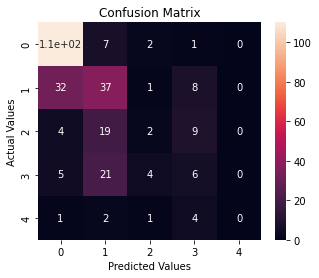

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       120
           1       0.43      0.47      0.45        78
           2       0.20      0.06      0.09        34
           3       0.21      0.17      0.19        36
           4       0.00      0.00      0.00         8

    accuracy                           0.56       276
   macro avg       0.31      0.32      0.31       276
weighted avg       0.49      0.56      0.51       276



c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

array([[110,   7,   2,   1,   0],
       [ 32,  37,   1,   8,   0],
       [  4,  19,   2,   9,   0],
       [  5,  21,   4,   6,   0],
       [  1,   2,   1,   4,   0]], dtype=int64)

In [72]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svc_model = SVC()
svc_model.fit(X_train_transform, y_train)
clf = svc_model.fit(X_train_transform, y_train)
clf.predict(X_train_transform)
y_pred = clf.predict(X_test_transform)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = [0, 1, 2, 3, 4], columns = [0, 1, 2, 3, 4])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
#y_preds = svc_model.predict(X_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

#### KNN

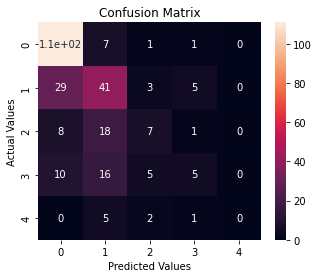

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       120
           1       0.47      0.53      0.50        78
           2       0.39      0.21      0.27        34
           3       0.38      0.14      0.20        36
           4       0.00      0.00      0.00         8

    accuracy                           0.59       276
   macro avg       0.39      0.36      0.35       276
weighted avg       0.54      0.59      0.55       276



c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

array([[111,   7,   1,   1,   0],
       [ 29,  41,   3,   5,   0],
       [  8,  18,   7,   1,   0],
       [ 10,  16,   5,   5,   0],
       [  0,   5,   2,   1,   0]], dtype=int64)

In [73]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=15, p=2, metric='euclidean')
knn_model.fit(X_train_transform, y_train)
#y_preds = knn_model.predict(X_test)

knn_mod = knn_model.fit(X_train_transform, y_train)
knn_mod.predict(X_train_transform)
y_pred = knn_mod.predict(X_test_transform)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = [0, 1, 2, 3, 4], columns = [0, 1, 2, 3, 4])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

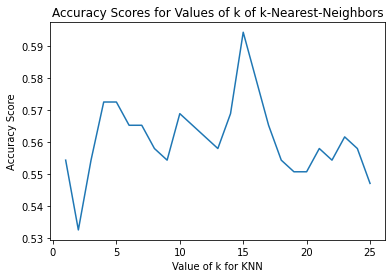

In [74]:
from sklearn import metrics
k_range = list(range(1,26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_transform, y_train)
    y_pred = knn.predict(X_test_transform)
    scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

#### BEST PARAMETERS

In [75]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
svm = SVC()
knn = KNeighborsClassifier()

data = [(lr, [{'C': [0.01, 0.1, 0.5, 1.0], 'random_state':[0]}]),
        (svm, [{'C': [0.1, 0.5, 1.0], 'kernel': ['linear', 'rbf'], 'random_state':[0]}]),
        (knn, [{'n_neighbors': [2, 3, 5, 7, 10, 15], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}])]

for i,j in data:
  grid = GridSearchCV(estimator = i , param_grid = j , scoring = 'accuracy',cv = 10)
  grid.fit(X_train,y_train)
  best_accuracy = grid.best_score_
  best_parameters = grid.best_params_
  print('{} \nBestAccuracy : {:.2f}%'.format(i,best_accuracy*100))
  print('BestParameters : ',best_parameters)
  print('')

c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LogisticRegression() 
BestAccuracy : 58.24%
BestParameters :  {'C': 0.5, 'random_state': 0}

SVC() 
BestAccuracy : 59.03%
BestParameters :  {'C': 1.0, 'kernel': 'linear', 'random_state': 0}

KNeighborsClassifier() 
BestAccuracy : 48.46%
BestParameters :  {'metric': 'manhattan', 'n_neighbors': 10}



#### ANN

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [77]:
y = df['num']
X = df.drop('num', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
from sklearn.neural_network import MLPClassifier

mlpcl = MLPClassifier(solver= "lbfgs", hidden_layer_sizes=(10, 10, 10, 8), max_iter=10000)
mlpcl.fit(X_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10, 8), max_iter=10000,
              solver='lbfgs')

In [80]:
predictions = mlpcl.predict(X_test)

[[96 15  6  3  0]
 [30 30  8 10  0]
 [ 7 14  5  8  0]
 [ 6 11  5 14  0]
 [ 1  3  0  4  0]]
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       120
           1       0.41      0.38      0.40        78
           2       0.21      0.15      0.17        34
           3       0.36      0.39      0.37        36
           4       0.00      0.00      0.00         8

    accuracy                           0.53       276
   macro avg       0.33      0.34      0.34       276
weighted avg       0.49      0.53      0.50       276



c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

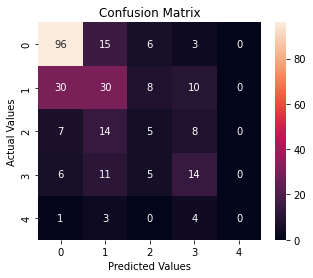

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       120
           1       0.41      0.38      0.40        78
           2       0.21      0.15      0.17        34
           3       0.36      0.39      0.37        36
           4       0.00      0.00      0.00         8

    accuracy                           0.53       276
   macro avg       0.33      0.34      0.34       276
weighted avg       0.49      0.53      0.50       276



c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

array([[96, 15,  6,  3,  0],
       [30, 30,  8, 10,  0],
       [ 7, 14,  5,  8,  0],
       [ 6, 11,  5, 14,  0],
       [ 1,  3,  0,  4,  0]], dtype=int64)

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index = [0, 1, 2, 3, 4], columns = [0, 1, 2, 3, 4])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)